#Initialization of the kaggle and the files#

In [1]:
# reading in the data via the Kaggle API

# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# install Kaggle
! pip install kaggle

Log into your Kaggle account, go to Account > API > Create new API token. You will obtain a kaggle.json file, which you save on your Google Drive directy in my drive.

In [3]:
!mkdir ~/.kaggle

In [4]:
#read in your Kaggle credentials from Google Drive
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json


In [5]:
! kaggle competitions download -c detecting-french-texts-difficulty-level-2023
from zipfile import ZipFile
with ZipFile('detecting-french-texts-difficulty-level-2023.zip','r') as zip:
  zip.extractall(path="")

  0% 0.00/303k [00:00<?, ?B/s]
100% 303k/303k [00:00<00:00, 81.3MB/s]


# Begining of the model#

In [6]:
!pip install transformers torch



## Imports##

In [17]:
# read in your training data
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from torch.utils.data import DataLoader, Dataset
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from google.colab import files
df = pd.read_csv('training_data.csv', index_col = 'id')
df_pred = pd.read_csv('unlabelled_test_data.csv', index_col = 'id')

In [8]:
df

,sentence,difficulty
id,,
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...
4795,"C'est pourquoi, il décida de remplacer les hab...",B2
4796,Il avait une de ces pâleurs splendides qui don...,C1
4797,"Et le premier samedi de chaque mois, venez ren...",A2


###Bert tokenizer and Bert model configuration
######We use 'bert-base-multilingual-cased' pre-trained model because the sentence are in french. This model is capable of processing text in several languages and to differentiate lower case and upper case letters.

In [9]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=len(df['difficulty'].unique())
)


bert_model=bert_model.to('cuda')

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#####Here we process some function and variable to be used latter for this model

In [10]:
class SentenceDataset(Dataset):
    def __init__(self, sentences, difficutly_level, tokenizer, max_length):
        self.sentences = sentences
        self.difficutly_level = difficutly_level
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

        if self.difficutly_level is not None:
            label = self.difficutly_level.iloc[idx]
            item['difficutly_level'] = torch.tensor(label, dtype=torch.long)

        return item

#####Data preparation (Label encoder, train,test split). The label was encoded like this

*   A1:0
*   A2:1
*   B1:2
*   B2:3
*   C1:4
*   C2:5

In [11]:
label_encoder = LabelEncoder()
df['encoded_difficulty'] = label_encoder.fit_transform(df['difficulty'])

X=df['sentence']
y=df['encoded_difficulty']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [12]:
df

,sentence,difficulty,encoded_difficulty
id,,,
0,Les coûts kilométriques réels peuvent diverger...,C1,4
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,0
2,Le test de niveau en français est sur le site ...,A1,0
3,Est-ce que ton mari est aussi de Boston?,A1,0
4,"Dans les écoles de commerce, dans les couloirs...",B1,2
...,...,...,...
4795,"C'est pourquoi, il décida de remplacer les hab...",B2,3
4796,Il avait une de ces pâleurs splendides qui don...,C1,4
4797,"Et le premier samedi de chaque mois, venez ren...",A2,1


#####Here we create our datasets,dataloaders who will be put in the model to be train and then we configure our training using Adamw as optimizer and CrossEntropyLoss function as our loss fuction

In [13]:

sentences_data = SentenceDataset(X_train, y_train, bert_tokenizer, max_length=128)
difficulty_data = SentenceDataset(X_test, y_test, bert_tokenizer, max_length=128)

sentence_loader = DataLoader(sentences_data, batch_size=16, shuffle=True)
difficulty_loader = DataLoader(difficulty_data, batch_size=16)

optimizer = AdamW(bert_model.parameters(), lr=5e-5)
loss_function = CrossEntropyLoss()

#####Now we can train our model


In [14]:
epochs = 3
for epoch in range(epochs):
    bert_model.train()
    for batch in sentence_loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        difficutly_level = batch['difficutly_level'].to('cuda')

        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_function(logits, difficutly_level)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
torch.save(bert_model.state_dict(), 'model_bert.pth')

#####Here we download the bert model in pth format to be used in streamlit


In [18]:
files.download('model_bert.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Here we evaluate our model

In [19]:
difficutly_predictions = []
true_difficulty = []

bert_model.eval()
total_loss = 0

with torch.no_grad():
    for batch in difficulty_loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        difficutly_level = batch['difficutly_level'].to('cuda')

        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = loss_function(logits, difficutly_level)
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        difficutly_predictions.extend(preds.cpu().numpy())
        true_difficulty.extend(difficutly_level.cpu().numpy())




#####We can see here our metrics

In [20]:
average_val_loss = total_loss / len(difficulty_loader)
precision = precision_score(true_difficulty, difficutly_predictions, average='macro')
recall = recall_score(true_difficulty, difficutly_predictions, average='macro')
f1 = f1_score(true_difficulty, difficutly_predictions, average='macro')
accuracy = accuracy_score(true_difficulty, difficutly_predictions)

print(f"Validation Loss: {average_val_loss}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Accuracy: {accuracy}")


Validation Loss: 1.1786821514368058
Precision: 0.5386125393086477
Recall: 0.535524801488409
F1-Score: 0.5280717824042093
Accuracy: 0.534375


#####Here our confusion matrix to see how good our trained labels are in comparaison to the true labels

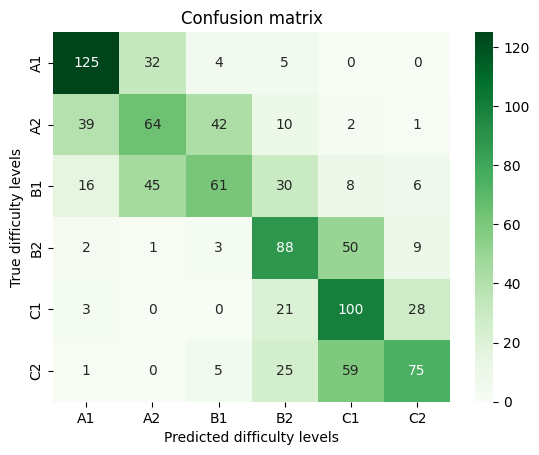

In [21]:
conf_matrix = confusion_matrix(true_difficulty, difficutly_predictions)
difficulty_labels=["A1","A2","B1","B2","C1","C2"]
sns.heatmap(conf_matrix, annot=True, fmt='g',xticklabels=difficulty_labels,yticklabels=difficulty_labels,cmap="Greens")
plt.xlabel('Predicted difficulty levels')
plt.ylabel('True difficulty levels')
plt.title('Confusion matrix')
plt.show()

#####Now we prdict our model on our unlabelled data

In [22]:
pred_dataset = SentenceDataset(df_pred['sentence'], None, bert_tokenizer, max_length=128)

pred_loader = DataLoader(pred_dataset, batch_size=16)

bert_model.eval()
predictions = []

with torch.no_grad():
    for batch in pred_loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')

        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)

        predictions.extend(predicted_labels.tolist())

##### The prediction is made in our encoder difficulty label so we inverse the encoding to have our initial labels

In [23]:
predictions=label_encoder.inverse_transform(predictions)
df_pred['difficulty']=predictions

# This is how to submit a pd file with predictions
### for the example we will submit a file where only A1 is given as a prediction

In [24]:
df_pred

,sentence,difficulty
id,,
0,Nous dûmes nous excuser des propos que nous eû...,C2
1,Vous ne pouvez pas savoir le plaisir que j'ai ...,A2
2,"Et, paradoxalement, boire froid n'est pas la b...",B1
3,"Ce n'est pas étonnant, car c'est une saison my...",B1
4,"Le corps de Golo lui-même, d'une essence aussi...",C2
...,...,...
1195,C'est un phénomène qui trouve une accélération...,B2
1196,Je vais parler au serveur et voir si on peut d...,A2
1197,Il n'était pas comme tant de gens qui par pare...,C2


In [25]:
df_sub=df_pred[['difficulty']]
df_sub.to_csv('submission.csv')

In [26]:
! kaggle competitions submit -c detecting-french-texts-difficulty-level-2023 -f submission.csv -m "Sample submission"

100% 8.30k/8.30k [00:00<00:00, 8.68kB/s]
400 - Bad Request - Submission not allowed:  Your team has used its daily Submission allowance (10) today, please try again tomorrow UTC (4.4 hours from now).


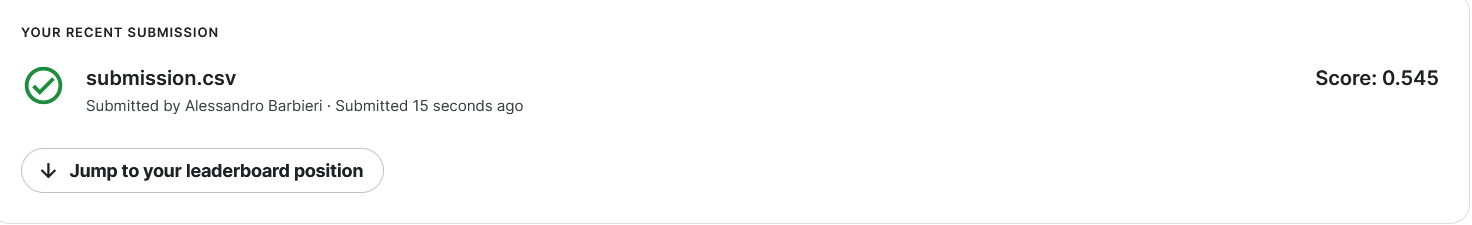